In [126]:
%pylab notebook
import cv2
import numpy as np
import utils
from numpy import matrix as mat
np.set_printoptions(formatter={'float':lambda x: '{:8.3f}'.format(x)})

Populating the interactive namespace from numpy and matplotlib


/home/ori/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['mat']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
def generate_3d_points():
    ax=np.linspace(-2,2,8)
    xx,yy=np.meshgrid(ax,ax)
    return np.vstack((xx.flatten(),yy.flatten(),np.zeros(len(ax)**2))).T
pts3d=generate_3d_points()
pts3d[:10,:]

array([[  -2.000,   -2.000,    0.000],
       [  -1.429,   -2.000,    0.000],
       [  -0.857,   -2.000,    0.000],
       [  -0.286,   -2.000,    0.000],
       [   0.286,   -2.000,    0.000],
       [   0.857,   -2.000,    0.000],
       [   1.429,   -2.000,    0.000],
       [   2.000,   -2.000,    0.000],
       [  -2.000,   -1.429,    0.000],
       [  -1.429,   -1.429,    0.000]])

<IPython.core.display.Javascript object>


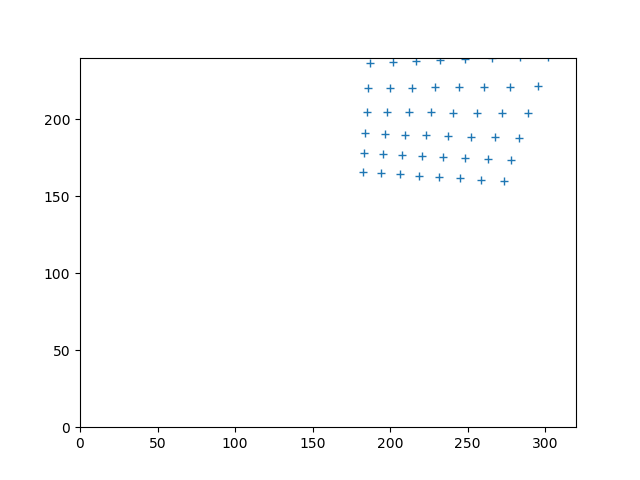

(0, 240)

In [82]:
K=mat([160.0,0,160, 0,160.0,120.0,0,0,1]).reshape(3,3)
x,y,z=1,0,8.0
rx,ry,rz=30/180.0*np.pi,-15/180.0*np.pi,0
R=utils.eulerAnglesToRotationMatrix([rx,ry,rz]) 
C=np.array([x,y,z])
#0=RC+T T=-R.T*C
T=-mat(R).T*mat(C).T
if 1:
    pts=(K*((mat(R).T*pts3d.T).T+T.T).T).T
    pts/=pts[:,2]
    pts=pts[:,:2]
else:
    R_vec,_=cv2.Rodrigues(R.T)
    pts,jac=cv2.projectPoints(pts3d,R_vec,T,K,np.zeros(5))
    pts=pts.reshape(-1,2)
plot(pts[:,0],pts[:,1],'+')
xlim([0,320])
ylim([0,240])
#(mat(R)*generate_3d_points().T).T

In [111]:
#esimaed camera position 0,0,7 (estimate camera positive altitude) esitmate rotation is 0,0,0
#0=RC+T T=-R.T*C => T=-C
estimate_CamPos=np.array([[   0.0],[   0.0],[   7.0]])
estimate_Rvec=np.array([[   0.0],[   0.0],[   0.0]])
estimate_Tvec=-estimate_CamPos
resPnP,Rvec,Tvec=cv2.solvePnP(pts3d,pts,K,np.zeros(5),estimate_Rvec,estimate_Tvec,True)
Rest,_=cv2.Rodrigues(Rvec)
angs=utils.rotationMatrixToEulerAngles(Rest.T)/np.pi*180
print('calculated camera angles')
print(angs)
print('calculated camera position')
###retriving camera position from translation vector
#0=RC+T C=-R.T*T
print(-mat(Rest).T*Tvec)


calculated camera angles
[  30.000  -15.000   -0.000]
calculated camera position
[[   1.000]
 [   0.000]
 [   8.000]]


<IPython.core.display.Javascript object>


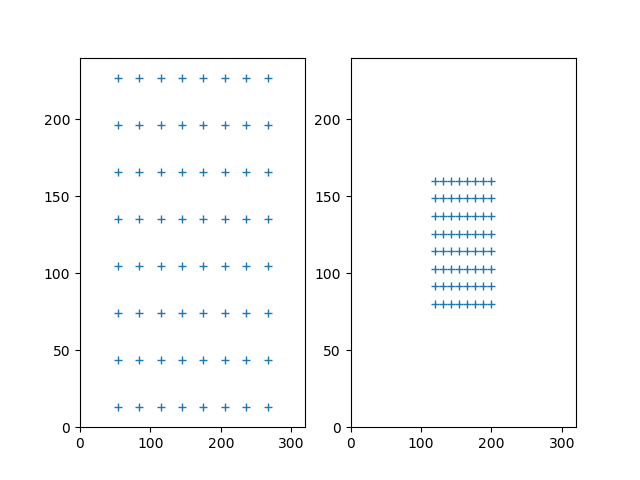

(0, 240)

In [234]:
#trangulate..
K=mat([160.0,0,160, 0,160.0,120.0,0,0,1]).reshape(3,3)
C1=np.array([0,0,3.0])
C2=np.array([0,0,8.0])

rx,ry,rz=0,0,0
R=utils.eulerAnglesToRotationMatrix([rx,ry,rz]) 
#print(R)
R_vec,_=cv2.Rodrigues(R)
#0=RC+T T=-R.T*C
T1=-mat(R).T*mat(C1).T
T2=-mat(R).T*mat(C2).T
pts1,_=cv2.projectPoints(pts3d,R_vec,T1,K,np.zeros(5))
pts1=pts1.reshape(-1,2)
#pts1=(K*((mat(R).T*pts3d.T).T+T1.T).T).T
#pts1/=pts1[:,2]
#pts1=pts1[:,:2]
pts2,_=cv2.projectPoints(pts3d,R_vec,T2,K,np.zeros(5))
pts2=pts2.reshape(-1,2)
#pts2=(K*((mat(R).T*pts3d.T).T+T2.T).T).T
#pts2/=pts2[:,2]
#pts2=pts2[:,:2]
figure()
subplot(1,2,1)
plot(pts1[:,0],pts1[:,1],'+')
xlim([0,320])
ylim([0,240])
subplot(1,2,2)
plot(pts2[:,0],pts2[:,1],'+')
xlim([0,320])
ylim([0,240])



<IPython.core.display.Javascript object>


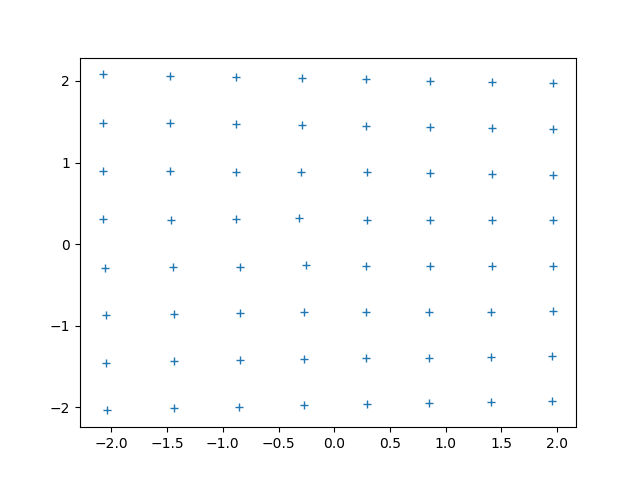

In [288]:
E,mask=cv2.findEssentialMat(pts1,pts2,K,cv2.RANSAC,0.999,1.0)
ret,R,T,mask=cv2.recoverPose(E,pts1,pts2,K,mask)
T=T.ravel()
estimated_alt=C2[2]-C1[2]
trans=np.array([T[0]/T[2], T[1]/T[2], 1.0]) * estimated_alt 
distortion=np.zeros(5)

p1=cv2.undistortPoints(pts1.reshape(-1,1,2),K,distortion).reshape(-1,2)
p2=cv2.undistortPoints(pts2.reshape(-1,1,2),K,distortion).reshape(-1,2)
#p1=pts1
#p2=pts2
###Proj1 = np.concatenate((np.dot(K,np.eye(3)),np.dot(K,np.zeros((3,1)))), axis = 1)
###Proj2 = np.concatenate((np.dot(K,R),np.dot(K,trans.reshape(3,1))), axis = 1)
#_,_,Proj1,Proj2,_,_,_=cv2.stereoRectify(K,distortion,K,distortion,(320,240),np.eye(3),trans)

Proj1=np.hstack((np.eye(3),np.zeros((3,1))))
Proj2=np.hstack((R,trans.reshape(3,1)))

#Proj1=np.vstack((np.eye(3),np.zeros((1,3)))).T
#Proj2=np.vstack((R,trans.reshape(1,3))).T
pts3d_trang=cv2.triangulatePoints(Proj2,Proj1,p2.T,p1.T)
#pts3d_trang=cv2.triangulatePoints(Proj2,Proj1,pts2.T,pts1.T)
pts3d_trang=pts3d_trang/pts3d_trang[3,:]
#pts3d_trang=(pts3d_trang.T/pts3d_trang[:,3]).T
#pts3d_trang=pts3d_trang[:3,:].T
figure()
plot(pts3d_trang.T[:,0],pts3d_trang.T[:,1],'+')
#plot(p1[:,0],p1[:,1],'+')
#p2.T[:4,:]


In [275]:
d=array([   0.000,    0.000,    0.000,    0.000,    0.000])
_,_,P1,P2,_,_,_=cv2.stereoRectify(K,distortion,K,d,(320,240),np.eye(3),trans)
P1


array([[ 160.000,    0.000,  145.655,    0.000],
       [   0.000,  160.000,  120.169,    0.000],
       [   0.000,    0.000,    1.000,    0.000]])

Mat_ LinearLSTriangulation(Point3d u,       //homogenous image point (u,v,1)
                   Matx34d P,       //camera 1 matrix
                   Point3d u1,      //homogenous image point in 2nd camera
                   Matx34d P1       //camera 2 matrix
                                   )
{
    //build matrix A for homogenous equation system Ax = 0
    //assume X = (x,y,z,1), for Linear-LS method
    //which turns it into a AX = B system, where A is 4x3, X is 3x1 and B is 4x1
    Matx43d A(u.x*P(2,0)-P(0,0),    u.x*P(2,1)-P(0,1),      u.x*P(2,2)-P(0,2),
          u.y*P(2,0)-P(1,0),    u.y*P(2,1)-P(1,1),      u.y*P(2,2)-P(1,2),
          u1.x*P1(2,0)-P1(0,0), u1.x*P1(2,1)-P1(0,1),   u1.x*P1(2,2)-P1(0,2),
          u1.y*P1(2,0)-P1(1,0), u1.y*P1(2,1)-P1(1,1),   u1.y*P1(2,2)-P1(1,2)
              );
    Mat_ B = (Mat_(4,1) <<    -(u.x*P(2,3)    -P(0,3)),
                      -(u.y*P(2,3)  -P(1,3)),
                      -(u1.x*P1(2,3)    -P1(0,3)),
                      -(u1.y*P1(2,3)    -P1(1,3)));
 
    Mat_ X;
    solve(A,B,X,DECOMP_SVD);
 
    return X;
}



/**
 From "Triangulation", Hartley, R.I. and Sturm, P., Computer vision and image understanding, 1997
 */
Mat_<double> IterativeLinearLSTriangulation(Point3d u,    //homogenous image point (u,v,1)
                                            Matx34d P,          //camera 1 matrix
                                            Point3d u1,         //homogenous image point in 2nd camera
                                            Matx34d P1          //camera 2 matrix
                                            ) {
    double wi = 1, wi1 = 1;
    Mat_<double> X(4,1); 
    for (int i=0; i<10; i++) { //Hartley suggests 10 iterations at most
        Mat_<double> X_ = LinearLSTriangulation(u,P,u1,P1);
        X(0) = X_(0); X(1) = X_(1); X(2) = X_(2); X_(3) = 1.0;
         
        //recalculate weights
        double p2x = Mat_<double>(Mat_<double>(P).row(2)*X)(0);
        double p2x1 = Mat_<double>(Mat_<double>(P1).row(2)*X)(0);
         
        //breaking point
        if(fabsf(wi - p2x) <= EPSILON && fabsf(wi1 - p2x1) <= EPSILON) break;
         
        wi = p2x;
        wi1 = p2x1;
         
        //reweight equations and solve
        Matx43d A((u.x*P(2,0)-P(0,0))/wi,       (u.x*P(2,1)-P(0,1))/wi,         (u.x*P(2,2)-P(0,2))/wi,     
                  (u.y*P(2,0)-P(1,0))/wi,       (u.y*P(2,1)-P(1,1))/wi,         (u.y*P(2,2)-P(1,2))/wi,     
                  (u1.x*P1(2,0)-P1(0,0))/wi1,   (u1.x*P1(2,1)-P1(0,1))/wi1,     (u1.x*P1(2,2)-P1(0,2))/wi1, 
                  (u1.y*P1(2,0)-P1(1,0))/wi1,   (u1.y*P1(2,1)-P1(1,1))/wi1,     (u1.y*P1(2,2)-P1(1,2))/wi1
                  );
        Mat_<double> B = (Mat_<double>(4,1) <<    -(u.x*P(2,3)    -P(0,3))/wi,
                          -(u.y*P(2,3)  -P(1,3))/wi,
                          -(u1.x*P1(2,3)    -P1(0,3))/wi1,
                          -(u1.y*P1(2,3)    -P1(1,3))/wi1
                          );
         
        solve(A,B,X_,DECOMP_SVD);
        X(0) = X_(0); X(1) = X_(1); X(2) = X_(2); X_(3) = 1.0;
    }
    return X;
}